In [1]:
import scipy
from scipy.stats import wilcoxon, ttest_rel, ttest_ind, ttest_1samp, mannwhitneyu, spearmanr, pearsonr
import scipy.io
import scipy.io.wavfile
import numpy as np
import matplotlib

In [2]:
get_ipython().run_line_magic('cd', '/Users/deepanshishokeen/desktop/capstone/work/amplitude-modulation-analysis-module')
from am_analysis import am_analysis as ama
mpl=matplotlib.pyplot

# Controls which version of the amplitude modulation spectrogram
mod_feat = 'power_modulation_spectrogram' 


/Users/deepanshishokeen/Desktop/Capstone/work/amplitude-modulation-analysis-module


In [3]:
power_rms = lambda x: np.sqrt(x.mean())
rms = lambda x: np.sqrt(np.square(x).mean())

# dB - power-decibel conversion
dB = lambda y: 10*np.log10(y)

# objfun : objective function to test divergence (x) from modulation-spectrum reference (y)
objfun = lambda x: dB((np.median(x,0).squeeze()/power_rms(x))) 

# TTEST : *ttest(objfun(x),objfun(y)), where *ttest returns t statistic and p value
def TTEST(x,y): 
    print("TTEST:",x.squeeze().shape,y.squeeze().shape)
    return mannwhitneyu(objfun(x.squeeze()),objfun(y.squeeze())) 

In [4]:
def test_mod(mod_spec, f_range=np.array([500,4000]), modf_range=np.array([30,60]), c_range=np.array([20,80]), ttl=None, avg=False, ref=None, hist=False):
    print("Freq Range:", f_range, ", ModFreq Range:", modf_range)
    mpl.figure()
    leg=[ttl.split(',')[0]+' Mean']
    mn=mod_spec[mod_feat] # MN is the M x N modulation envelope
    amx=mod_spec['freq_mod_axis']
    amy=mod_spec['freq_axis']
    midx=np.where((amx>=modf_range[0]) & (amx<modf_range[1]))[0]
    midy=np.where((amy>=f_range[0]) & (amy<f_range[1]))[0]
    if ref is None: 
        rf=mn
    else:
        rf = ref
    print("TTEST RAW DATA: ", mn[midy][:,midx,:].shape, rf[midy][:,midx,:].shape)
    w=TTEST(mn[midy][:,midx,:],rf[midy][:,midx,:])
    print(w)
    p=w[1]
    if not (hist or avg):
        ama.plot_modulation_spectrogram_data(mod_spec, f_range=f_range, modf_range=modf_range, c_range=c_range, c_map=mpl.cm.gray_r)
        mpl.xlabel('Modulator Frequency (Hz)', fontsize=16)
        mpl.ylabel('Carrier Frequency (Hz)', fontsize=16)
        if ttl is not None:
            ttl=ttl+', U=%2.1f, p=%0.3f'%(w[0],w[1])
    elif not hist:
        mpl.plot(amx[midx],objfun(mn[midy][:,midx,:]))
        if ref is not None:
            mpl.plot(amx[midx],objfun(rf[midy][:,midx,:]),'r--')
            leg.append('REF Mean')
            if ttl is None:
                ttl=''
            else:
                ttl=ttl+', U=%3.5f, p=%3.5f'%(w[0],w[1])
        mpl.legend(leg, fontsize=16)
        mpl.ylabel('Avg Pwr (dB)', fontsize=14)
        mpl.xlabel('Amplitude Modulation Frequency', fontsize=14)
        mpl.grid()
    else:
        mpl.hist([objfun(mn[midy][:,midx,:].squeeze()),objfun(rf[midy][:,midx,:].squeeze())],30)
        mpl.grid()
    if ttl is not None:
        mpl.title(ttl,fontsize=16)        
    mpl.show()
    return w

In [5]:
def avg_mod(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', t_range=None, FL=2, FR=1, N=1024, hop=0.005):
    # FL = Frame Length (seconds) 
    # FR = Frame Rate (frames per second) 
    #  N = STFT Length 
    
    fs,x = scipy.io.wavfile.read(fname, mmap=True)
    print(fs,len(x))
    if not len(x):
        print( "File not read:", fname )
        return
    else:
        print ( "Loaded",fname,"len:",len(x) )
        
    # Amplitude Modulaton Spectrum Analysis
    win_size = int(fs*FL)
    win_shift = int(fs/FR)
    if t_range is None:
        t_range = [60,120]
    sig = x[t_range[0]*fs:t_range[1]*fs,0].reshape(-1,1) # LEFT CHANNEL
    sig = sig / rms(sig) # normalize RMS 
    print ("sig: win_size=%d,"%win_size, "win_shift=%d,"%win_shift, "sig.shape=%d,%d"%(sig.shape) )
    x_segmented, _, _ = ama.epoching(sig, win_size, win_size-win_shift)
    n_segments  = x_segmented.shape[2]
    print("n_segments=%d"%n_segments)
    mod_spec = []
    # Loop over epochs: (len(sig)-win_size) / win_shift
    for i_segment in range(0,n_segments):
        x_tmp = x_segmented[:,:,i_segment]
        ms=ama.strfft_modulation_spectrogram(x_tmp, fs, N, int(fs*hop))
        mod_spec.append(ms)
    print(mod_spec[0][mod_feat].shape)
    data = []
    for m in mod_spec:    
        data.append(m[mod_feat][:,:,0])
    data = np.array(data)    
    nmm = data.mean(0) # average modulation spectrum
    mod_spec[0][mod_feat][:,:,0]=nmm
    print("mod_spec.shape ",data.shape, "->", nmm.shape)
    return mod_spec[0]

In [6]:
# Default is K448
def get_mod_spec(fname='/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', T=[0,1,2], ttl='Mozart K.448', avg=False, hist=False, plotting=True, ref=None):
    res = []
    tst = []
    for t in T:
        res.append(avg_mod(fname=fname, t_range=[t*60,(t+1)*60]))
        if plotting:
            tst.append(test_mod(res[t], ttl='%s, T=%02d:00-%02d:00'%(ttl,t,t+1), avg=avg, ref=ref, hist=hist))
            mpl.show()
    return res, tst 

In [7]:
matplotlib.rcParams['figure.figsize']=(12,6)
def make_reference_mod_spec(x):
    y=np.array([r[mod_feat] for r in x]).mean(0)
    return y

In [8]:
def show_obj_fun(res,ref=None):
    rr=np.array([r[mod_feat].squeeze() for r in res])
    print(rr.shape)
    h=mpl.imshow(objfun(rr),origin='lower',aspect='auto',cmap=mpl.cm.coolwarm)
    mpl.title('Mod_Spec Musical Piece',fontsize=20)
    mpl.colorbar()
    mpl.xlabel("Time", fontsize=12)
    mpl.ylabel("Frequency (Hz)", fontsize=12)
    mpl.figure()
    if ref is not None:
        ref=ref
        ref=np.array([r[mod_feat].squeeze() for r in ref])
        mpl.figure()
        h=mpl.imshow(objfun(ref),origin='lower',aspect='auto',cmap=mpl.cm.coolwarm)
        mpl.title('Mod_Spec Reference (Mozart K448)',fontsize=20)
        mpl.colorbar()
        mpl.xlabel("Time", fontsize=12)
        mpl.ylabel("Frequency (Hz)", fontsize=12)
        mpl.figure()
        h=mpl.imshow(objfun(rr)-objfun(ref),origin='lower',aspect='auto',cmap=mpl.cm.coolwarm)
        mpl.title('Mod_Spec Musical Piece - Reference (Mozart K448)',fontsize=20)
        mpl.colorbar()
        mpl.xlabel("Time", fontsize=12)
        mpl.ylabel("Frequency (Hz)", fontsize=12)
        mpl.figure()
        

44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)


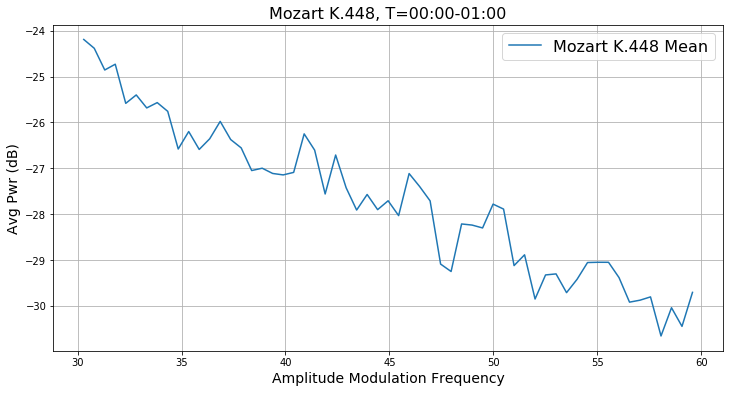

44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)


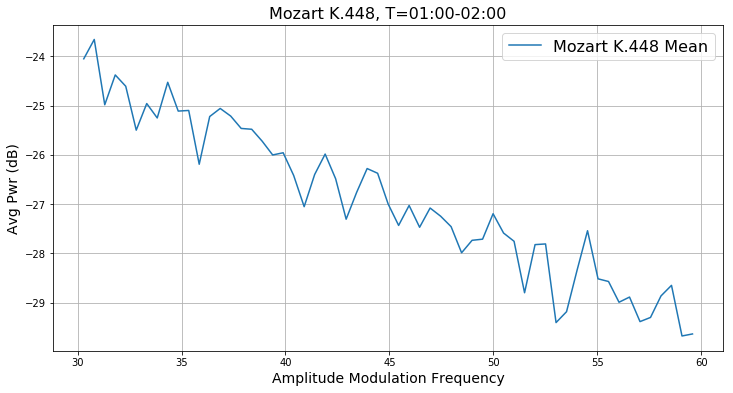

44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
sig: win_size=88200, win_shift=44100, sig.shape=1223969,1
n_segments=26
(513, 199, 1)
mod_spec.shape  (26, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1740.5, pvalue=0.4989262789424854)


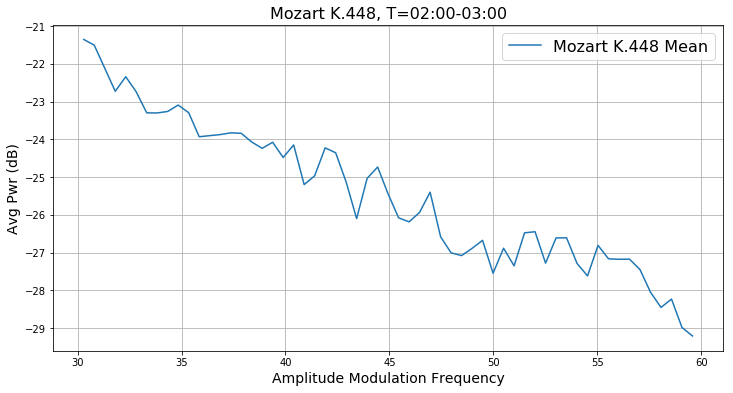

In [9]:
res_448, w_448 = get_mod_spec('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav', avg=True)


44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1118.0, pvalue=0.0004073240586396526)


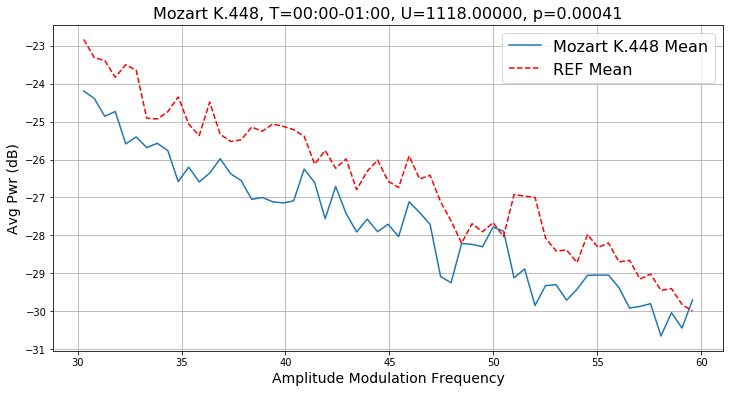

44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1532.0, pvalue=0.13146104518274554)


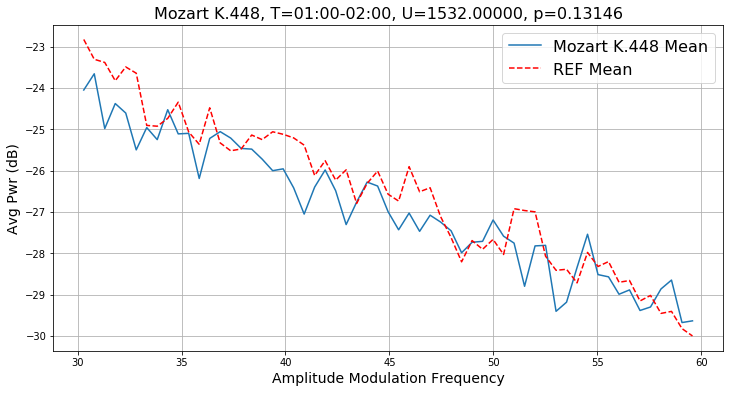

44100 6515969
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/MozartK448_SonataTwoPianosDMaj.wav len: 6515969
sig: win_size=88200, win_shift=44100, sig.shape=1223969,1
n_segments=26
(513, 199, 1)
mod_spec.shape  (26, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1237.0, pvalue=0.003391854562128479)


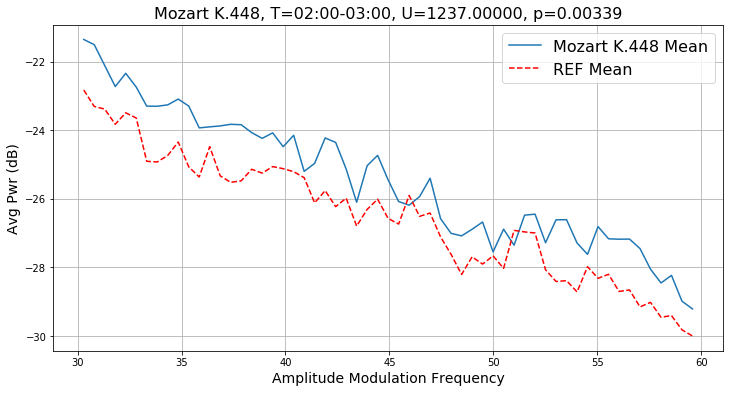

In [10]:
ref_448 = make_reference_mod_spec(res_448)
res_448, w_448 = get_mod_spec(avg=True, ref=ref_448)

In [11]:
ref_448 = make_reference_mod_spec(res_448)

44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=420.0, pvalue=6.033983115530341e-13)


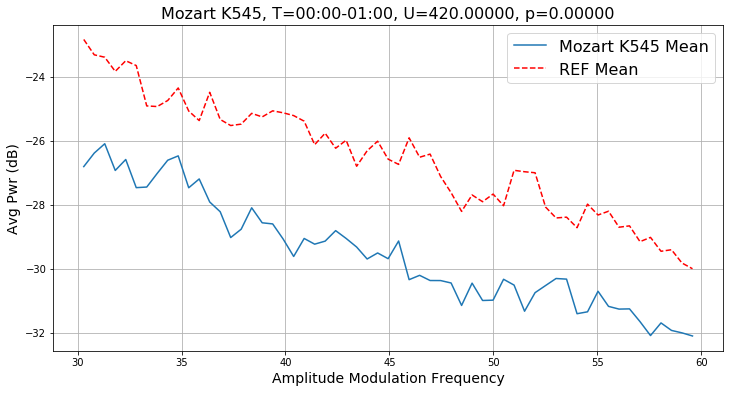

44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1488.0, pvalue=0.08749694638880912)


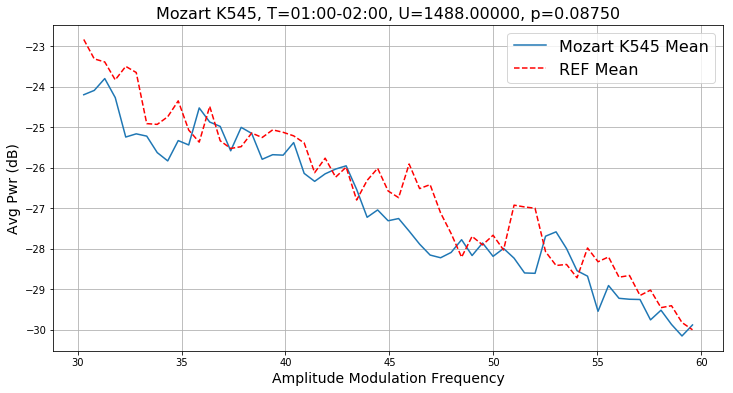

44100 7332675
Loaded /Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav len: 7332675
sig: win_size=88200, win_shift=44100, sig.shape=2040675,1
n_segments=45
(513, 199, 1)
mod_spec.shape  (45, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1210.0, pvalue=0.0021681528383346474)


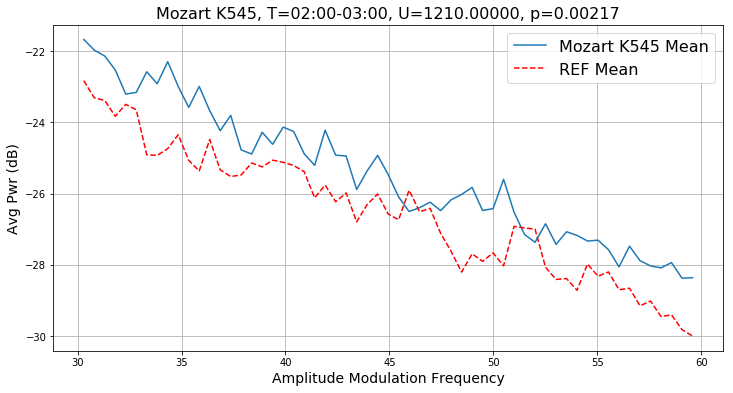

In [12]:
res_545, w_545 = get_mod_spec('/Users/deepanshishokeen/Desktop/Capstone/work/modspectrum/Mozart_PianoSonata16CMaj.wav', ttl='Mozart K545', ref=ref_448, avg=True)


(3, 513, 199)


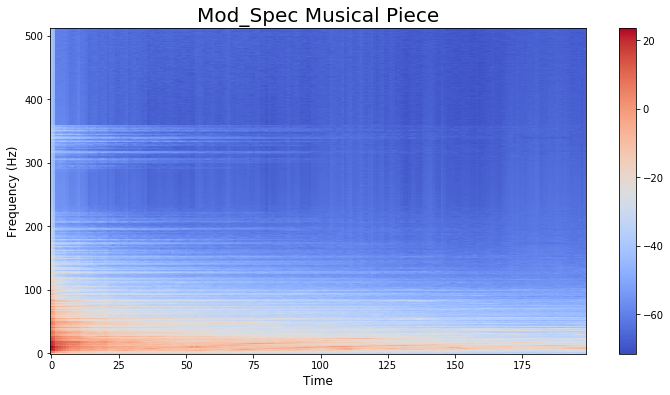

<Figure size 864x432 with 0 Axes>

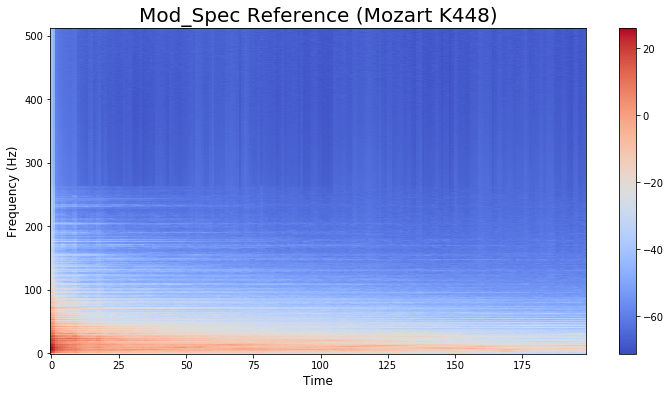

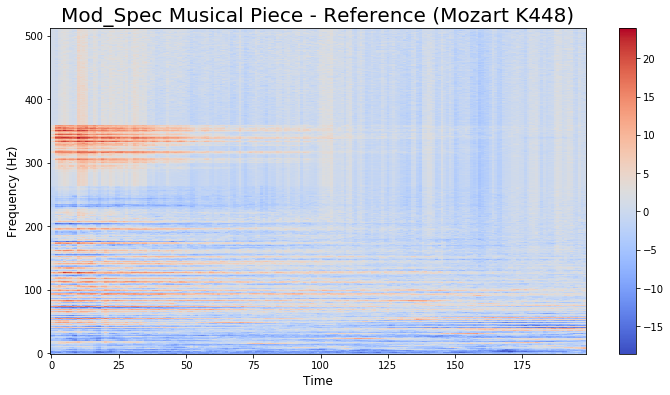

<Figure size 864x432 with 0 Axes>

In [13]:
show_obj_fun(res_545,ref=res_448)

44100 6174000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Nikita Magaloff - Mazurka in B flat, Op. 17, No. 1.wav len: 6174000
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1103.0, pvalue=0.0003034596561060548)


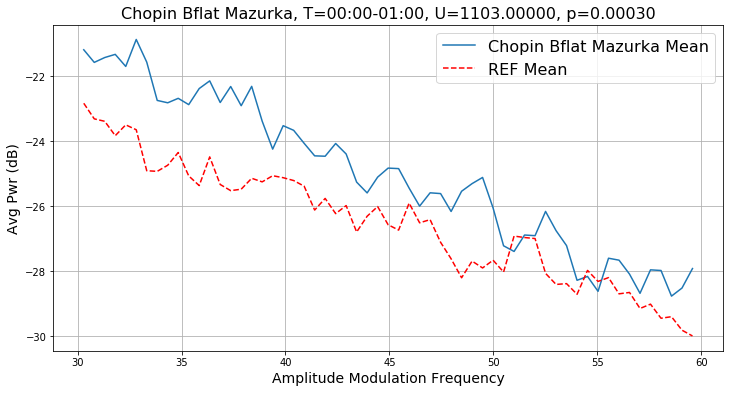

44100 6174000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Nikita Magaloff - Mazurka in B flat, Op. 17, No. 1.wav len: 6174000
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=1577.0, pvalue=0.19015933005767138)


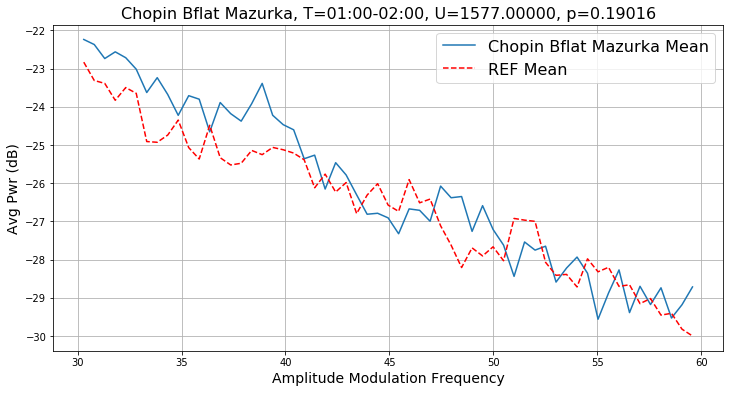

44100 6174000
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Nikita Magaloff - Mazurka in B flat, Op. 17, No. 1.wav len: 6174000
sig: win_size=88200, win_shift=44100, sig.shape=882000,1
n_segments=19
(513, 199, 1)
mod_spec.shape  (19, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=969.0, pvalue=1.6643614199594907e-05)


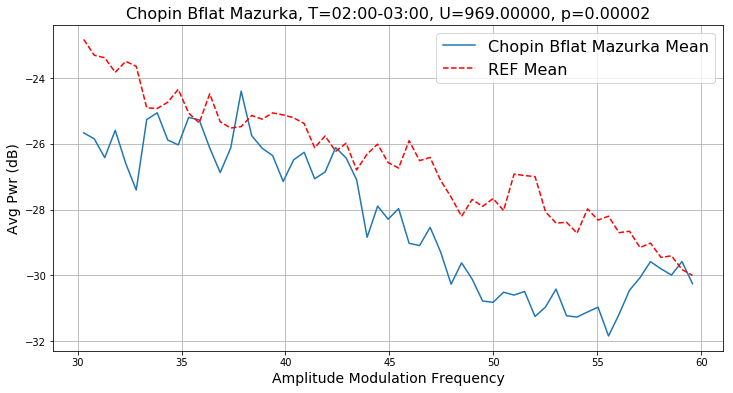

In [14]:
res_ChopinMazurkaBflat,w = get_mod_spec('/Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/07 Nikita Magaloff - Mazurka in B flat, Op. 17, No. 1.wav',  ttl='Chopin Bflat Mazurka', ref=ref_448, avg=True)
#/Volumes/LaCie/PSYC90 Corpus Study

44100 16140600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Ronald Brautigam - Sonata No.16 in C major, KV.545 - II. Andante.wav len: 16140600
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)


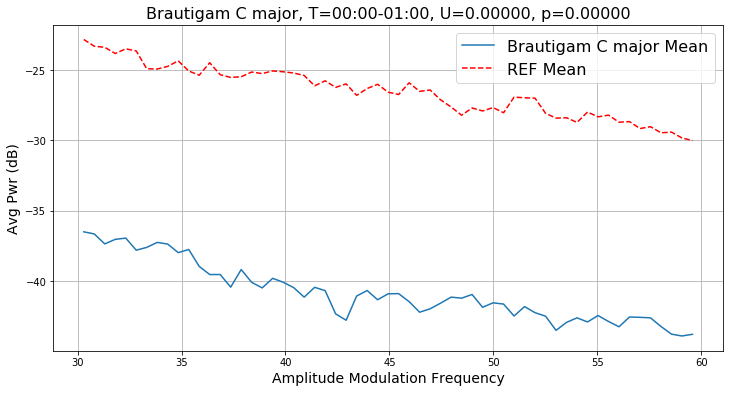

44100 16140600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Ronald Brautigam - Sonata No.16 in C major, KV.545 - II. Andante.wav len: 16140600
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)


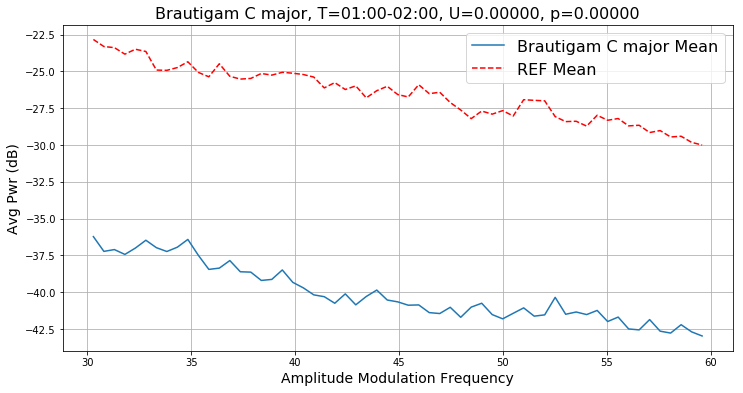

44100 16140600
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Ronald Brautigam - Sonata No.16 in C major, KV.545 - II. Andante.wav len: 16140600
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=0.0, pvalue=3.7973954466182726e-21)


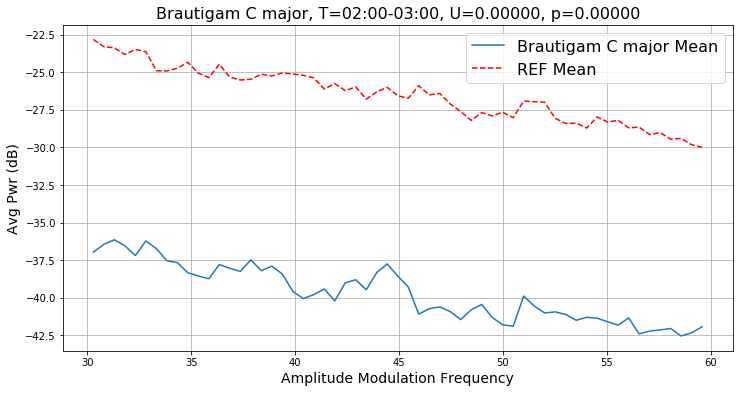

In [15]:
res_BrautigamFmajor,w = get_mod_spec('/Volumes/LaCie/PSYC90 Corpus Study/Extra Pieces/05 Ronald Brautigam - Sonata No.16 in C major, KV.545 - II. Andante.wav',  ttl='Brautigam C major', ref=ref_448, avg=True)


44100 6092856
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/02 Leslie Howard - Piano Sonata in B minor, S178, 002 Allegro energico.wav len: 6092856
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=706.0, pvalue=1.3087888470591612e-08)


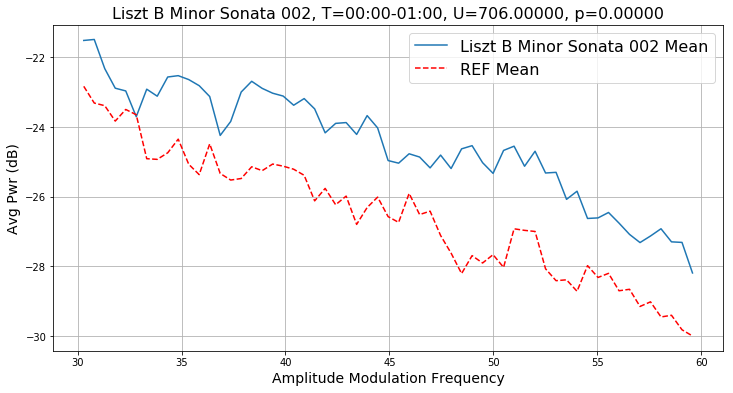

44100 6092856
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/02 Leslie Howard - Piano Sonata in B minor, S178, 002 Allegro energico.wav len: 6092856
sig: win_size=88200, win_shift=44100, sig.shape=2646000,1
n_segments=59
(513, 199, 1)
mod_spec.shape  (59, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=317.0, pvalue=9.371942957180812e-15)


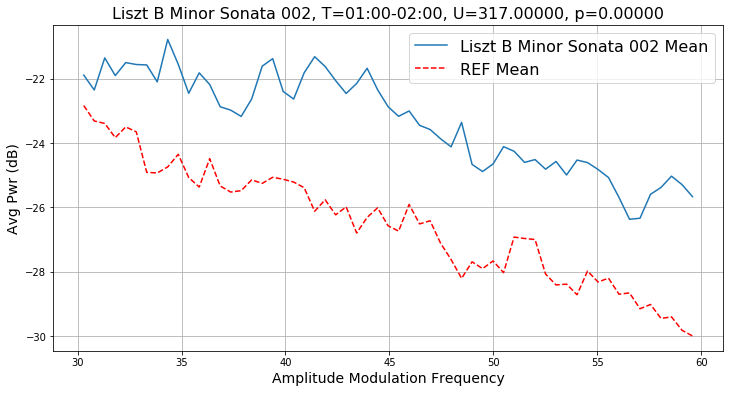

44100 6092856
Loaded /Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/02 Leslie Howard - Piano Sonata in B minor, S178, 002 Allegro energico.wav len: 6092856
sig: win_size=88200, win_shift=44100, sig.shape=800856,1
n_segments=17
(513, 199, 1)
mod_spec.shape  (17, 513, 199) -> (513, 199)
Freq Range: [ 500 4000] , ModFreq Range: [30 60]
TTEST RAW DATA:  (81, 59, 1) (81, 59, 1)
TTEST: (81, 59) (81, 59)
MannwhitneyuResult(statistic=573.0, pvalue=1.6808853831818488e-10)


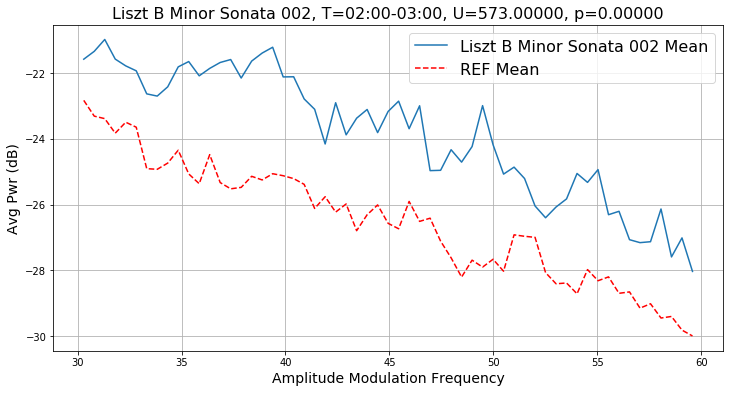

In [16]:
res_LisztSonataBMinor,w = get_mod_spec('/Volumes/LaCie/PSYC90 Corpus Study/Liszt Sonata in B Minor/02 Leslie Howard - Piano Sonata in B minor, S178, 002 Allegro energico.wav',  ttl='Liszt B Minor Sonata 002', ref=ref_448, avg=True)
